In [332]:
import gym
import numpy as np
import pandas as pd
import random
from scipy import stats

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.initializers import RandomNormal

import collections

%matplotlib inline

In [426]:
class SineEnv(gym.Env):
    
    
    def __init__(self, n=600):
        self.n = n
        self.series = 3 + 0.01 * np.sin(0.06*np.arange(self.n))
        
    def reset(self):
        self.index = 0
        self.done = False
        return self.series[self.index]
        
    def step(self, action):
        self.index += 1
        
        obs = self.series[self.index]
        step_return = np.log(self.series[self.index]/self.series[self.index-1])
        reward = (action - 1) * step_return
        
        if self.index >= (self.n-1):
            self.done = True
            
        info = {
            'return': step_return
        }
        
        return obs, reward, self.done, info

In [427]:
class RandomAgent(object):
    
    def __init__(self, num_actions=3, replay_buffer_size=1000):
        
        self.num_actions = num_actions
        self.replay_buffer_size = replay_buffer_size
        self._replay = collections.deque(maxlen=self.replay_buffer_size)
        
    def initialise_episode(self, observation):
        return self._select_action()
        
    def step(self, reward, observation):
        return self._select_action()
    
    def _select_action(self):
        return np.random.randint(self.num_actions)

In [437]:
class DQNAgent(object):
    
    def __init__(
        self,
        num_actions=3,
        replay_buffer_size=2000,
        stack_size=8,
        learning_rate=0.001,
        batch_size=32,
        gamma=0.99,
        normalisation_window=96
    ):
        self.num_actions = num_actions
        self.replay_buffer_size = replay_buffer_size
        self.stack_size = stack_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.gamma = gamma
        self.normalisation_window = normalisation_window
        self.series = []
        self._replay = collections.deque(maxlen=self.replay_buffer_size)
        
        self.online_network = self._build_model(name='online')
        self.target_network = self._build_model(name='target')
        
        self.training_history = []
        self.training_step = 0
        
    def _build_model(self, name='default'):
        
        model = Sequential(name=name)
        model.add(Dense(24, input_dim=self.stack_size, activation='elu'))
        model.add(Dense(128, activation='elu'))
        model.add(Dense(self.num_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
        
    def initialise_episode(self, initial_observation):
        initial_size = self.stack_size
        self.series.extend([initial_observation] * initial_size)
        self.state = self.construct_state(initial_observation)
        return self._select_action()
        
    def step(self, reward, observation):
        self.current_state = self.construct_state(observation)
        experience = (self.state, self.action, reward, self.current_state)
        
        self._train_step()
        self._replay.append(experience)
        print("Experience: {}".format(experience))
        self.state = self.current_state
        return self._select_action()
    
    def construct_state(self, observation):
        self.series.append(observation)
        log_ret = np.log(np.array(agent.series[1:])/np.array(agent.series[:-1]))
        return np.nan_to_num(log_ret[-self.stack_size:])
    
    def _select_action(self):
        predict_batch = np.array([self.state])
        action_values = self.model.predict(predict_batch)
        self.action = np.argmax(action_values[0])
        return self.action
    
    def _train_step(self):
        if len(self._replay) < self.batch_size:
            return
        minibatch = random.sample(self._replay, self.batch_size)
        
        train_batch = []
        target_batch = []
        for (state, action, reward, next_state) in minibatch:
            current_state_batch = np.array([state])
            next_state_batch = np.array([next_state])

            # Get the Q-values
            Q_online_current = self.online_network.predict(
                current_state_batch)[0]
            Q_target_next = self.model.predict(
                next_state_batch)[0]
            Q_online_next = self.model.predict(
                next_state_batch)[0]

            # Double DQN uses online network for argmax and target
            # network for value of that argmax
            next_action = np.argmax(Q_online_next)
            target = reward + self.gamma * Q_target_next[next_action]

            # Make the Bellman update on target (Y) value
            Q_online_current[action] = target
            train_batch.append(state)
            target_batch.append(Q_online_current)

        # Train the online network on the minibatch
        X_train = np.array(train_batch)
        y_train = np.array(target_batch)
        history = self.model.fit(X_train, y_train, epochs=1)
        self.training_history.extend(history.history['loss'])
        self.training_step += 1
        
    def end_episode(self, reward, observation):
        plt.plot(self.training_history)
        plt.title("Loss function")

Experience: (array([0., 0., 0., 0., 0., 0., 0., 0.]), 0, -0.00019986004824805223, array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00019986]))
Experience: (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00019986]), 2, 0.00019910104715225948, array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00019986, 0.0001991 ]))
Experience: (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00019986, 0.0001991 ]), 2, 0.00019762615578372387, array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00019986, 0.0001991 , 0.00019763]))
Experience: (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00019986, 0.0001991 , 0.00019763]), 2, 0.00019544109962803046, array([0.        , 0.        , 0.        , 0.        , 0.00019986,
       0.0001991 , 0.00019763, 0.00019544]))
Experience: (a

Epoch 1/1
32/32 [==============================] - 2s 55ms/step - loss: 5.4677e-09
Experience: (array([ 2.00556451e-05,  8.12871775e-06, -3.82717338e-06, -1.57694278e-05,
       -2.76554924e-05, -3.94430078e-05, -5.10899559e-05, -6.25548041e-05]), 0, 7.37966504840556e-05, array([ 8.12871775e-06, -3.82717338e-06, -1.57694278e-05, -2.76554924e-05,
       -3.94430078e-05, -5.10899559e-05, -6.25548041e-05, -7.37966505e-05]))
Epoch 1/1
32/32 [==============================] - 0s 82us/step - loss: 1.5162e-05
Experience: (array([ 8.12871775e-06, -3.82717338e-06, -1.57694278e-05, -2.76554924e-05,
       -3.94430078e-05, -5.10899559e-05, -6.25548041e-05, -7.37966505e-05]), 2, -8.477536495506717e-05, array([-3.82717338e-06, -1.57694278e-05, -2.76554924e-05, -3.94430078e-05,
       -5.10899559e-05, -6.25548041e-05, -7.37966505e-05, -8.47753650e-05]))
Epoch 1/1
32/32 [==============================] - 0s 82us/step - loss: 4.6127e-06
Experience: (array([-3.82717338e-06, -1.57694278e-05, -2.76554924

Epoch 1/1
32/32 [==============================] - 0s 108us/step - loss: 1.5879e-07
Experience: (array([-0.00018303, -0.00018752, -0.00019135, -0.00019448, -0.00019692,
       -0.00019865, -0.00019967, -0.00019997]), 0, 0.0001995477439623, array([-0.00018752, -0.00019135, -0.00019448, -0.00019692, -0.00019865,
       -0.00019967, -0.00019997, -0.00019955]))
Epoch 1/1
32/32 [==============================] - 0s 95us/step - loss: 5.6306e-07
Experience: (array([-0.00018752, -0.00019135, -0.00019448, -0.00019692, -0.00019865,
       -0.00019967, -0.00019997, -0.00019955]), 1, -0.0, array([-0.00019135, -0.00019448, -0.00019692, -0.00019865, -0.00019967,
       -0.00019997, -0.00019955, -0.00019841]))
Epoch 1/1
32/32 [==============================] - 0s 83us/step - loss: 1.3929e-07
Experience: (array([-0.00019135, -0.00019448, -0.00019692, -0.00019865, -0.00019967,
       -0.00019997, -0.00019955, -0.00019841]), 1, -0.0, array([-0.00019448, -0.00019692, -0.00019865, -0.00019967, -0.00019997

Experience: (array([-1.23305980e-04, -1.13617440e-04, -1.03516629e-04, -9.30400780e-05,
       -8.22257146e-05, -7.11127256e-05, -5.97414118e-05, -4.81530382e-05]), 2, -3.6389680882515524e-05, array([-1.13617440e-04, -1.03516629e-04, -9.30400780e-05, -8.22257146e-05,
       -7.11127256e-05, -5.97414118e-05, -4.81530382e-05, -3.63896809e-05]))
Epoch 1/1
32/32 [==============================] - 0s 91us/step - loss: 8.3700e-08
Experience: (array([-1.13617440e-04, -1.03516629e-04, -9.30400780e-05, -8.22257146e-05,
       -7.11127256e-05, -5.97414118e-05, -4.81530382e-05, -3.63896809e-05]), 0, 2.449407011442121e-05, array([-1.03516629e-04, -9.30400780e-05, -8.22257146e-05, -7.11127256e-05,
       -5.97414118e-05, -4.81530382e-05, -3.63896809e-05, -2.44940701e-05]))
Epoch 1/1
32/32 [==============================] - 0s 114us/step - loss: 1.4432e-07
Experience: (array([-1.03516629e-04, -9.30400780e-05, -8.22257146e-05, -7.11127256e-05,
       -5.97414118e-05, -4.81530382e-05, -3.63896809e-05,

Experience: (array([0.0001027 , 0.00011283, 0.00012255, 0.00013183, 0.00014063,
       0.00014892, 0.00015667, 0.00016385]), 0, -0.000170443901855342, array([0.00011283, 0.00012255, 0.00013183, 0.00014063, 0.00014892,
       0.00015667, 0.00016385, 0.00017044]))
Epoch 1/1
32/32 [==============================] - 0s 105us/step - loss: 2.1745e-08
Experience: (array([0.00011283, 0.00012255, 0.00013183, 0.00014063, 0.00014892,
       0.00015667, 0.00016385, 0.00017044]), 0, -0.00017641771803927726, array([0.00012255, 0.00013183, 0.00014063, 0.00014892, 0.00015667,
       0.00016385, 0.00017044, 0.00017642]))
Epoch 1/1
32/32 [==============================] - 0s 88us/step - loss: 2.5683e-08
Experience: (array([0.00012255, 0.00013183, 0.00014063, 0.00014892, 0.00015667,
       0.00016385, 0.00017044, 0.00017642]), 2, 0.0001817536262222858, array([0.00013183, 0.00014063, 0.00014892, 0.00015667, 0.00016385,
       0.00017044, 0.00017642, 0.00018175]))
Epoch 1/1
32/32 [=========================

Epoch 1/1
32/32 [==============================] - 0s 92us/step - loss: 4.0742e-09
Experience: (array([0.00017831, 0.00017257, 0.00016621, 0.00015926, 0.00015174,
       0.00014367, 0.00013509, 0.00012603]), 2, 0.00011652162337411832, array([0.00017257, 0.00016621, 0.00015926, 0.00015174, 0.00014367,
       0.00013509, 0.00012603, 0.00011652]))
Epoch 1/1
32/32 [==============================] - 0s 79us/step - loss: 2.9742e-09
Experience: (array([0.00017257, 0.00016621, 0.00015926, 0.00015174, 0.00014367,
       0.00013509, 0.00012603, 0.00011652]), 1, 0.0, array([0.00016621, 0.00015926, 0.00015174, 0.00014367, 0.00013509,
       0.00012603, 0.00011652, 0.00010659]))
Epoch 1/1
32/32 [==============================] - 0s 70us/step - loss: 1.1779e-08
Experience: (array([0.00016621, 0.00015926, 0.00015174, 0.00014367, 0.00013509,
       0.00012603, 0.00011652, 0.00010659]), 1, 0.0, array([1.59257776e-04, 1.51735734e-04, 1.43671148e-04, 1.35093079e-04,
       1.26032389e-04, 1.16521623e-04,

Epoch 1/1
32/32 [==============================] - 0s 118us/step - loss: 5.8036e-09
Experience: (array([-3.09706383e-05, -4.27229799e-05, -5.43230596e-05, -6.57295073e-05,
       -7.69016228e-05, -8.77995179e-05, -9.83842548e-05, -1.08617982e-04]), 0, 0.0001184640686328691, array([-4.27229799e-05, -5.43230596e-05, -6.57295073e-05, -7.69016228e-05,
       -8.77995179e-05, -9.83842548e-05, -1.08617982e-04, -1.18464069e-04]))
Epoch 1/1
32/32 [==============================] - 0s 169us/step - loss: 2.2026e-09
Experience: (array([-4.27229799e-05, -5.43230596e-05, -6.57295073e-05, -7.69016228e-05,
       -8.77995179e-05, -9.83842548e-05, -1.08617982e-04, -1.18464069e-04]), 0, 0.00012788723061923828, array([-5.43230596e-05, -6.57295073e-05, -7.69016228e-05, -8.77995179e-05,
       -9.83842548e-05, -1.08617982e-04, -1.18464069e-04, -1.27887231e-04]))
Epoch 1/1
32/32 [==============================] - 0s 102us/step - loss: 1.8426e-09
Experience: (array([-5.43230596e-05, -6.57295073e-05, -7.6901

Epoch 1/1
32/32 [==============================] - 0s 116us/step - loss: 2.6016e-09
Experience: (array([-0.00019901, -0.00019983, -0.00019992, -0.0001993 , -0.00019796,
       -0.00019591, -0.00019315, -0.00018969]), 0, 0.00018554750742639842, array([-0.00019983, -0.00019992, -0.0001993 , -0.00019796, -0.00019591,
       -0.00019315, -0.00018969, -0.00018555]))
Epoch 1/1
32/32 [==============================] - 0s 137us/step - loss: 3.4421e-09
Experience: (array([-0.00019983, -0.00019992, -0.0001993 , -0.00019796, -0.00019591,
       -0.00019315, -0.00018969, -0.00018555]), 1, -0.0, array([-0.00019992, -0.0001993 , -0.00019796, -0.00019591, -0.00019315,
       -0.00018969, -0.00018555, -0.00018074]))
Epoch 1/1
32/32 [==============================] - 0s 77us/step - loss: 2.5924e-09
Experience: (array([-0.00019992, -0.0001993 , -0.00019796, -0.00019591, -0.00019315,
       -0.00018969, -0.00018555, -0.00018074]), 0, 0.00017526979773622675, array([-0.0001993 , -0.00019796, -0.00019591, -

Experience: (array([-7.91397587e-05, -6.79502668e-05, -5.65139235e-05, -4.48722370e-05,
       -3.30674826e-05, -2.11425453e-05, -9.14075973e-06,  2.89425185e-06]), 0, -1.4918742914798393e-05, array([-6.79502668e-05, -5.65139235e-05, -4.48722370e-05, -3.30674826e-05,
       -2.11425453e-05, -9.14075973e-06,  2.89425185e-06,  1.49187429e-05]))
Epoch 1/1
32/32 [==============================] - 0s 102us/step - loss: 2.9092e-09
Experience: (array([-6.79502668e-05, -5.65139235e-05, -4.48722370e-05, -3.30674826e-05,
       -2.11425453e-05, -9.14075973e-06,  2.89425185e-06,  1.49187429e-05]), 1, 0.0, array([-5.65139235e-05, -4.48722370e-05, -3.30674826e-05, -2.11425453e-05,
       -9.14075973e-06,  2.89425185e-06,  1.49187429e-05,  2.68890063e-05]))
Epoch 1/1
32/32 [==============================] - 0s 95us/step - loss: 2.5837e-09
Experience: (array([-5.65139235e-05, -4.48722370e-05, -3.30674826e-05, -2.11425453e-05,
       -9.14075973e-06,  2.89425185e-06,  1.49187429e-05,  2.68890063e-05])

Epoch 1/1
32/32 [==============================] - 0s 93us/step - loss: 7.8519e-09
Experience: (array([0.00015115, 0.00015874, 0.00016576, 0.00017218, 0.00017798,
       0.00018313, 0.00018762, 0.00019144]), 0, -0.00019456149768532283, array([0.00015874, 0.00016576, 0.00017218, 0.00017798, 0.00018313,
       0.00018762, 0.00019144, 0.00019456]))
Epoch 1/1
32/32 [==============================] - 0s 143us/step - loss: 3.5219e-09
Experience: (array([0.00015874, 0.00016576, 0.00017218, 0.00017798, 0.00018313,
       0.00018762, 0.00019144, 0.00019456]), 2, 0.00019698301856198097, array([0.00016576, 0.00017218, 0.00017798, 0.00018313, 0.00018762,
       0.00019144, 0.00019456, 0.00019698]))
Epoch 1/1
32/32 [==============================] - 0s 120us/step - loss: 2.3147e-09
Experience: (array([0.00016576, 0.00017218, 0.00017798, 0.00018313, 0.00018762,
       0.00019144, 0.00019456, 0.00019698]), 2, 0.00019869438597736668, array([0.00017218, 0.00017798, 0.00018313, 0.00018762, 0.00019144,
 

Epoch 1/1
32/32 [==============================] - 0s 89us/step - loss: 1.6958e-09
Experience: (array([1.49529177e-04, 1.41317679e-04, 1.32601171e-04, 1.23410997e-04,
       1.13780156e-04, 1.03743179e-04, 9.33360159e-05, 8.25959001e-05]), 2, 7.156122229653616e-05, array([1.41317679e-04, 1.32601171e-04, 1.23410997e-04, 1.13780156e-04,
       1.03743179e-04, 9.33360159e-05, 8.25959001e-05, 7.15612223e-05]))
Epoch 1/1
32/32 [==============================] - 0s 95us/step - loss: 1.7085e-09
Experience: (array([1.41317679e-04, 1.32601171e-04, 1.23410997e-04, 1.13780156e-04,
       1.03743179e-04, 9.33360159e-05, 8.25959001e-05, 7.15612223e-05]), 0, -6.027139446404029e-05, array([1.32601171e-04, 1.23410997e-04, 1.13780156e-04, 1.03743179e-04,
       9.33360159e-05, 8.25959001e-05, 7.15612223e-05, 6.02713945e-05]))
Epoch 1/1
32/32 [==============================] - 0s 83us/step - loss: 4.0575e-09
Experience: (array([1.32601171e-04, 1.23410997e-04, 1.13780156e-04, 1.03743179e-04,
       9.333

Epoch 1/1
32/32 [==============================] - 0s 123us/step - loss: 4.5789e-09
Experience: (array([-6.88858017e-05, -7.99850529e-05, -9.07990698e-05, -1.01289205e-04,
       -1.11417937e-04, -1.21148999e-04, -1.30447507e-04, -1.39280086e-04]), 2, -0.00014761498641857547, array([-7.99850529e-05, -9.07990698e-05, -1.01289205e-04, -1.11417937e-04,
       -1.21148999e-04, -1.30447507e-04, -1.39280086e-04, -1.47614986e-04]))
Epoch 1/1
32/32 [==============================] - 0s 100us/step - loss: 2.2183e-09
Experience: (array([-7.99850529e-05, -9.07990698e-05, -1.01289205e-04, -1.11417937e-04,
       -1.21148999e-04, -1.30447507e-04, -1.39280086e-04, -1.47614986e-04]), 0, 0.0001554221994556708, array([-9.07990698e-05, -1.01289205e-04, -1.11417937e-04, -1.21148999e-04,
       -1.30447507e-04, -1.39280086e-04, -1.47614986e-04, -1.55422199e-04]))
Epoch 1/1
32/32 [==============================] - 0s 98us/step - loss: 1.4521e-09
Experience: (array([-9.07990698e-05, -1.01289205e-04, -1.1141

Epoch 1/1
32/32 [==============================] - 0s 188us/step - loss: 4.8336e-09
Experience: (array([-0.00019746, -0.0001952 , -0.00019225, -0.0001886 , -0.00018427,
       -0.00017927, -0.00017362, -0.00016735]), 0, 0.00016047170096989414, array([-0.0001952 , -0.00019225, -0.0001886 , -0.00018427, -0.00017927,
       -0.00017362, -0.00016735, -0.00016047]))
Epoch 1/1
32/32 [==============================] - 0s 83us/step - loss: 4.9805e-09
Experience: (array([-0.0001952 , -0.00019225, -0.0001886 , -0.00018427, -0.00017927,
       -0.00017362, -0.00016735, -0.00016047]), 2, -0.00015301201854271693, array([-0.00019225, -0.0001886 , -0.00018427, -0.00017927, -0.00017362,
       -0.00016735, -0.00016047, -0.00015301]))
Epoch 1/1
32/32 [==============================] - 0s 92us/step - loss: 1.4902e-08
Experience: (array([-0.00019225, -0.0001886 , -0.00018427, -0.00017927, -0.00017362,
       -0.00016735, -0.00016047, -0.00015301]), 2, -0.00014499810731893954, array([-0.0001886 , -0.00018

Epoch 1/1
32/32 [==============================] - 0s 93us/step - loss: 1.2218e-08
Experience: (array([-2.97358427e-05, -1.77849832e-05, -5.76947843e-06,  6.26699817e-06,
        1.82806945e-05,  3.02279439e-05,  4.20653281e-05,  5.37498401e-05]), 1, 0.0, array([-1.77849832e-05, -5.76947843e-06,  6.26699817e-06,  1.82806945e-05,
        3.02279439e-05,  4.20653281e-05,  5.37498401e-05,  6.52390445e-05]))
Epoch 1/1
32/32 [==============================] - 0s 97us/step - loss: 8.7793e-09
Experience: (array([-1.77849832e-05, -5.76947843e-06,  6.26699817e-06,  1.82806945e-05,
        3.02279439e-05,  4.20653281e-05,  5.37498401e-05,  6.52390445e-05]), 1, 0.0, array([-5.76947843e-06,  6.26699817e-06,  1.82806945e-05,  3.02279439e-05,
        4.20653281e-05,  5.37498401e-05,  6.52390445e-05,  7.64912357e-05]))
Epoch 1/1
32/32 [==============================] - 0s 110us/step - loss: 1.0311e-08
Experience: (array([-5.76947843e-06,  6.26699817e-06,  1.82806945e-05,  3.02279439e-05,
        4.20

Epoch 1/1
32/32 [==============================] - 0s 99us/step - loss: 1.3541e-08
Experience: (array([0.00018446, 0.00018876, 0.00019238, 0.00019531, 0.00019753,
       0.00019905, 0.00019984, 0.00019991]), 2, 0.00019926997094444, array([0.00018876, 0.00019238, 0.00019531, 0.00019753, 0.00019905,
       0.00019984, 0.00019991, 0.00019927]))
Epoch 1/1
32/32 [==============================] - 0s 88us/step - loss: 1.0152e-08
Experience: (array([0.00018876, 0.00019238, 0.00019531, 0.00019753, 0.00019905,
       0.00019984, 0.00019991, 0.00019927]), 1, 0.0, array([0.00019238, 0.00019531, 0.00019753, 0.00019905, 0.00019984,
       0.00019991, 0.00019927, 0.00019791]))
Epoch 1/1
32/32 [==============================] - 0s 79us/step - loss: 2.3135e-08
Experience: (array([0.00019238, 0.00019531, 0.00019753, 0.00019905, 0.00019984,
       0.00019991, 0.00019927, 0.00019791]), 0, -0.00019583633935957762, array([0.00019531, 0.00019753, 0.00019905, 0.00019984, 0.00019991,
       0.00019927, 0.0001

Epoch 1/1
32/32 [==============================] - 0s 78us/step - loss: 4.1585e-08
Experience: (array([1.11006782e-04, 1.00862380e-04, 9.03581010e-05, 7.95315174e-05,
       6.84213196e-05, 5.70671814e-05, 4.55096217e-05, 3.37898636e-05]), 1, 0.0, array([1.00862380e-04, 9.03581010e-05, 7.95315174e-05, 6.84213196e-05,
       5.70671814e-05, 4.55096217e-05, 3.37898636e-05, 2.19496911e-05]))
Epoch 1/1
32/32 [==============================] - 0s 72us/step - loss: 1.2773e-08
Experience: (array([1.00862380e-04, 9.03581010e-05, 7.95315174e-05, 6.84213196e-05,
       5.70671814e-05, 4.55096217e-05, 3.37898636e-05, 2.19496911e-05]), 1, 0.0, array([9.03581010e-05, 7.95315174e-05, 6.84213196e-05, 5.70671814e-05,
       4.55096217e-05, 3.37898636e-05, 2.19496911e-05, 1.00313047e-05]))
Epoch 1/1
32/32 [==============================] - 0s 93us/step - loss: 1.1736e-08
Experience: (array([9.03581010e-05, 7.95315174e-05, 6.84213196e-05, 5.70671814e-05,
       4.55096217e-05, 3.37898636e-05, 2.19496911

Epoch 1/1
32/32 [==============================] - 0s 72us/step - loss: 1.3866e-07
Experience: (array([-0.00011419, -0.0001238 , -0.00013297, -0.00014167, -0.00014986,
       -0.00015751, -0.0001646 , -0.0001711 ]), 0, 0.0001769932803014851, array([-0.0001238 , -0.00013297, -0.00014167, -0.00014986, -0.00015751,
       -0.0001646 , -0.0001711 , -0.00017699]))
Epoch 1/1
32/32 [==============================] - 0s 80us/step - loss: 2.2335e-07
Experience: (array([-0.0001238 , -0.00013297, -0.00014167, -0.00014986, -0.00015751,
       -0.0001646 , -0.0001711 , -0.00017699]), 0, 0.00018224838458242033, array([-0.00013297, -0.00014167, -0.00014986, -0.00015751, -0.0001646 ,
       -0.0001711 , -0.00017699, -0.00018225]))
Epoch 1/1
32/32 [==============================] - 0s 89us/step - loss: 4.2685e-07
Experience: (array([-0.00013297, -0.00014167, -0.00014986, -0.00015751, -0.0001646 ,
       -0.0001711 , -0.00017699, -0.00018225]), 2, -0.00018685027686050445, array([-0.00014167, -0.00014986

Epoch 1/1
32/32 [==============================] - 0s 119us/step - loss: 4.8315e-06
Experience: (array([-0.00018293, -0.00017775, -0.00017193, -0.00016548, -0.00015844,
       -0.00015082, -0.00014266, -0.00013398]), 0, 0.0001248086220533538, array([-0.00017775, -0.00017193, -0.00016548, -0.00015844, -0.00015082,
       -0.00014266, -0.00013398, -0.00012481]))
Epoch 1/1
32/32 [==============================] - 0s 114us/step - loss: 2.0663e-06
Experience: (array([-0.00017775, -0.00017193, -0.00016548, -0.00015844, -0.00015082,
       -0.00014266, -0.00013398, -0.00012481]), 1, -0.0, array([-0.00017193, -0.00016548, -0.00015844, -0.00015082, -0.00014266,
       -0.00013398, -0.00012481, -0.00011519]))
Epoch 1/1
32/32 [==============================] - 0s 79us/step - loss: 1.0344e-05
Experience: (array([-0.00017193, -0.00016548, -0.00015844, -0.00015082, -0.00014266,
       -0.00013398, -0.00012481, -0.00011519]), 1, -0.0, array([-0.00016548, -0.00015844, -0.00015082, -0.00014266, -0.0001

Experience: (array([9.63795489e-06, 2.16374261e-05, 3.35582505e-05, 4.53571089e-05,
       5.69911382e-05, 6.84180917e-05, 7.95964965e-05, 9.04858078e-05]), 2, 0.00010104655932711024, array([2.16374261e-05, 3.35582505e-05, 4.53571089e-05, 5.69911382e-05,
       6.84180917e-05, 7.95964965e-05, 9.04858078e-05, 1.01046559e-04]))
Epoch 1/1
32/32 [==============================] - 0s 161us/step - loss: 1.2955e-06
Experience: (array([2.16374261e-05, 3.35582505e-05, 4.53571089e-05, 5.69911382e-05,
       6.84180917e-05, 7.95964965e-05, 9.04858078e-05, 1.01046559e-04]), 1, 0.0, array([3.35582505e-05, 4.53571089e-05, 5.69911382e-05, 6.84180917e-05,
       7.95964965e-05, 9.04858078e-05, 1.01046559e-04, 1.11240509e-04]))
Epoch 1/1
32/32 [==============================] - 0s 113us/step - loss: 1.0973e-06
Experience: (array([3.35582505e-05, 4.53571089e-05, 5.69911382e-05, 6.84180917e-05,
       7.95964965e-05, 9.04858078e-05, 1.01046559e-04, 1.11240509e-04]), 1, 0.0, array([4.53571089e-05, 5.69911

Experience: (array([0.00019803, 0.00019934, 0.00019993, 0.00019981, 0.00019896,
       0.0001974 , 0.00019513, 0.00019216]), 2, 0.00018849692968772998, array([0.00019934, 0.00019993, 0.00019981, 0.00019896, 0.0001974 ,
       0.00019513, 0.00019216, 0.0001885 ]))
Epoch 1/1
32/32 [==============================] - 0s 83us/step - loss: 1.7056e-07
Experience: (array([0.00019934, 0.00019993, 0.00019981, 0.00019896, 0.0001974 ,
       0.00019513, 0.00019216, 0.0001885 ]), 2, 0.00018415994818634127, array([0.00019993, 0.00019981, 0.00019896, 0.0001974 , 0.00019513,
       0.00019216, 0.0001885 , 0.00018416]))
Epoch 1/1
32/32 [==============================] - 0s 86us/step - loss: 5.5056e-07
Experience: (array([0.00019993, 0.00019981, 0.00019896, 0.0001974 , 0.00019513,
       0.00019216, 0.0001885 , 0.00018416]), 0, -0.00017916275890238686, array([0.00019981, 0.00019896, 0.0001974 , 0.00019513, 0.00019216,
       0.0001885 , 0.00018416, 0.00017916]))
Epoch 1/1
32/32 [========================

Epoch 1/1
32/32 [==============================] - 0s 87us/step - loss: 2.3903e-08
Experience: (array([ 6.52622534e-05,  5.38469879e-05,  4.22397887e-05,  3.04820503e-05,
        1.86156884e-05,  6.68299378e-06, -5.27351317e-06, -1.72112300e-05]), 0, 2.9087618961449475e-05, array([ 5.38469879e-05,  4.22397887e-05,  3.04820503e-05,  1.86156884e-05,
        6.68299378e-06, -5.27351317e-06, -1.72112300e-05, -2.90876190e-05]))
Epoch 1/1
32/32 [==============================] - 0s 74us/step - loss: 2.9912e-08
Experience: (array([ 5.38469879e-05,  4.22397887e-05,  3.04820503e-05,  1.86156884e-05,
        6.68299378e-06, -5.27351317e-06, -1.72112300e-05, -2.90876190e-05]), 0, 4.086035454009477e-05, array([ 4.22397887e-05,  3.04820503e-05,  1.86156884e-05,  6.68299378e-06,
       -5.27351317e-06, -1.72112300e-05, -2.90876190e-05, -4.08603545e-05]))
Epoch 1/1
32/32 [==============================] - 0s 127us/step - loss: 2.6099e-08
Experience: (array([ 4.22397887e-05,  3.04820503e-05,  1.861568

Experience: (array([-0.00015206, -0.00015956, -0.00016648, -0.00017282, -0.00017853,
       -0.0001836 , -0.00018802, -0.00019176]), 0, 0.0001948148600825196, array([-0.00015956, -0.00016648, -0.00017282, -0.00017853, -0.0001836 ,
       -0.00018802, -0.00019176, -0.00019481]))
Epoch 1/1
32/32 [==============================] - 0s 198us/step - loss: 1.7686e-08
Experience: (array([-0.00015956, -0.00016648, -0.00017282, -0.00017853, -0.0001836 ,
       -0.00018802, -0.00019176, -0.00019481]), 0, 0.00019716844471417592, array([-0.00016648, -0.00017282, -0.00017853, -0.0001836 , -0.00018802,
       -0.00019176, -0.00019481, -0.00019717]))
Epoch 1/1
32/32 [==============================] - 0s 163us/step - loss: 8.3506e-09
Experience: (array([-0.00016648, -0.00017282, -0.00017853, -0.0001836 , -0.00018802,
       -0.00019176, -0.00019481, -0.00019717]), 0, 0.00019881360944898213, array([-0.00017282, -0.00017853, -0.0001836 , -0.00018802, -0.00019176,
       -0.00019481, -0.00019717, -0.00019

Epoch 1/1
32/32 [==============================] - 0s 92us/step - loss: 1.1602e-08
Experience: (array([-1.56360519e-04, -1.48586769e-04, -1.40274683e-04, -1.31454157e-04,
       -1.22156967e-04, -1.12416657e-04, -1.02268419e-04, -9.17489562e-05]), 1, -0.0, array([-1.48586769e-04, -1.40274683e-04, -1.31454157e-04, -1.22156967e-04,
       -1.12416657e-04, -1.02268419e-04, -9.17489562e-05, -8.08963581e-05]))
Epoch 1/1
32/32 [==============================] - 0s 79us/step - loss: 1.2239e-08
Experience: (array([-1.48586769e-04, -1.40274683e-04, -1.31454157e-04, -1.22156967e-04,
       -1.12416657e-04, -1.02268419e-04, -9.17489562e-05, -8.08963581e-05]), 2, -6.97499536534019e-05, array([-1.40274683e-04, -1.31454157e-04, -1.22156967e-04, -1.12416657e-04,
       -1.02268419e-04, -9.17489562e-05, -8.08963581e-05, -6.97499537e-05]))
Epoch 1/1
32/32 [==============================] - 0s 80us/step - loss: 1.8603e-08
Experience: (array([-1.40274683e-04, -1.31454157e-04, -1.22156967e-04, -1.12416657

Epoch 1/1
32/32 [==============================] - 0s 83us/step - loss: 1.2562e-08
Experience: (array([6.02161684e-05, 7.15776130e-05, 8.26790463e-05, 9.34802107e-05,
       1.03941969e-04, 1.14026447e-04, 1.23697177e-04, 1.32919227e-04]), 1, 0.0, array([7.15776130e-05, 8.26790463e-05, 9.34802107e-05, 1.03941969e-04,
       1.14026447e-04, 1.23697177e-04, 1.32919227e-04, 1.41659333e-04]))
Epoch 1/1
32/32 [==============================] - 0s 79us/step - loss: 8.3100e-09
Experience: (array([7.15776130e-05, 8.26790463e-05, 9.34802107e-05, 1.03941969e-04,
       1.14026447e-04, 1.23697177e-04, 1.32919227e-04, 1.41659333e-04]), 1, 0.0, array([8.26790463e-05, 9.34802107e-05, 1.03941969e-04, 1.14026447e-04,
       1.23697177e-04, 1.32919227e-04, 1.41659333e-04, 1.49886014e-04]))
Epoch 1/1
32/32 [==============================] - 0s 121us/step - loss: 3.2765e-09
Experience: (array([8.26790463e-05, 9.34802107e-05, 1.03941969e-04, 1.14026447e-04,
       1.23697177e-04, 1.32919227e-04, 1.4165933

Epoch 1/1
32/32 [==============================] - 0s 81us/step - loss: 6.0753e-09
Experience: (array([0.00019683, 0.00019437, 0.0001912 , 0.00018735, 0.00018283,
       0.00017765, 0.00017183, 0.0001654 ]), 2, 0.0001583775342659351, array([0.00019437, 0.0001912 , 0.00018735, 0.00018283, 0.00017765,
       0.00017183, 0.0001654 , 0.00015838]))
Epoch 1/1
32/32 [==============================] - 0s 112us/step - loss: 6.0199e-09
Experience: (array([0.00019437, 0.0001912 , 0.00018735, 0.00018283, 0.00017765,
       0.00017183, 0.0001654 , 0.00015838]), 2, 0.0001507883726114906, array([0.0001912 , 0.00018735, 0.00018283, 0.00017765, 0.00017183,
       0.0001654 , 0.00015838, 0.00015079]))
Epoch 1/1
32/32 [==============================] - 0s 171us/step - loss: 2.9530e-09
Experience: (array([0.0001912 , 0.00018735, 0.00018283, 0.00017765, 0.00017183,
       0.0001654 , 0.00015838, 0.00015079]), 2, 0.00014266008299515417, array([0.00018735, 0.00018283, 0.00017765, 0.00017183, 0.0001654 ,
    

Epoch 1/1
32/32 [==============================] - 0s 123us/step - loss: 4.0295e-09
Experience: (array([ 1.52764747e-05,  3.33281219e-06, -8.62272547e-06, -2.05475391e-05,
       -3.23991358e-05, -4.41352755e-05, -5.57141174e-05, -6.70943649e-05]), 2, -7.823540877538553e-05, array([ 3.33281219e-06, -8.62272547e-06, -2.05475391e-05, -3.23991358e-05,
       -4.41352755e-05, -5.57141174e-05, -6.70943649e-05, -7.82354088e-05]))
Epoch 1/1
32/32 [==============================] - 0s 120us/step - loss: 8.7746e-09
Experience: (array([ 3.33281219e-06, -8.62272547e-06, -2.05475391e-05, -3.23991358e-05,
       -4.41352755e-05, -5.57141174e-05, -6.70943649e-05, -7.82354088e-05]), 2, -8.90974682037536e-05, array([-8.62272547e-06, -2.05475391e-05, -3.23991358e-05, -4.41352755e-05,
       -5.57141174e-05, -6.70943649e-05, -7.82354088e-05, -8.90974682e-05]))
Epoch 1/1
32/32 [==============================] - 0s 85us/step - loss: 3.1612e-09
Experience: (array([-8.62272547e-06, -2.05475391e-05, -3.23991

Epoch 1/1
32/32 [==============================] - 0s 103us/step - loss: 5.7398e-09
Experience: (array([-0.00018491, -0.00018914, -0.00019269, -0.00019555, -0.0001977 ,
       -0.00019915, -0.00019988, -0.00019989]), 0, 0.00019917675458724072, array([-0.00018914, -0.00019269, -0.00019555, -0.0001977 , -0.00019915,
       -0.00019988, -0.00019989, -0.00019918]))
Epoch 1/1
32/32 [==============================] - 0s 84us/step - loss: 6.2089e-09
Experience: (array([-0.00018914, -0.00019269, -0.00019555, -0.0001977 , -0.00019915,
       -0.00019988, -0.00019989, -0.00019918]), 0, 0.00019774988778162848, array([-0.00019269, -0.00019555, -0.0001977 , -0.00019915, -0.00019988,
       -0.00019989, -0.00019918, -0.00019775]))
Epoch 1/1
32/32 [==============================] - 0s 91us/step - loss: 3.6218e-09
Experience: (array([-0.00019269, -0.00019555, -0.0001977 , -0.00019915, -0.00019988,
       -0.00019989, -0.00019918, -0.00019775]), 0, 0.00019561027058381445, array([-0.00019555, -0.0001977

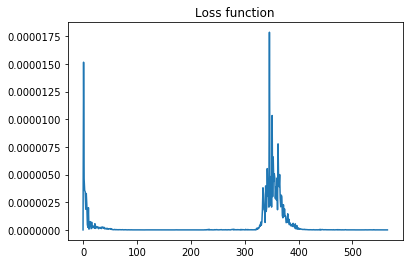

In [440]:
env = SineEnv()
agent= DQNAgent()

obs = env.reset()
action = agent.initialise_episode(obs)
done = False
steps = 0
agent_rewards = []
benchmark_rewards = []

while not done:
    obs, reward, done, info = env.step(action)
    agent_rewards.append(reward)
    benchmark_rewards.append(info['return'])
    steps += 1
    if not done:
        action = agent.step(reward, obs)

agent.end_episode(reward, obs)

In [441]:
rewards = pd.DataFrame(
    {
        'Agent': np.cumsum(agent_rewards),
        'Benchmark': np.cumsum(benchmark_rewards)
    })

Total rewards: 0.024130538265495147


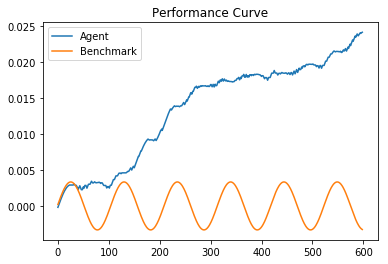

In [442]:
rewards.plot(title="Performance Curve")
print("Total rewards: {}".format(np.sum(agent_rewards)))

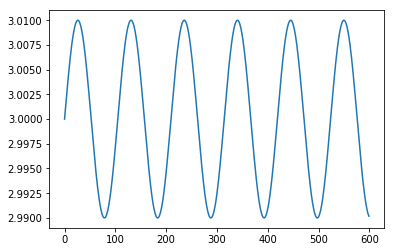

In [443]:
plt.plot(env.series)

(0.00019997043880990448, -0.00019996910485977877)

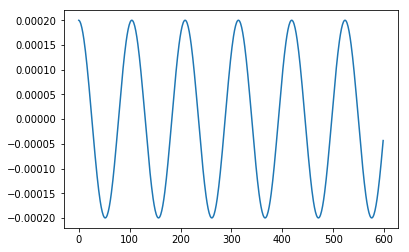

In [444]:
plt.plot(np.log(env.series[1:]/env.series[:-1]))
(np.max((np.log(env.series[1:]/env.series[:-1]))), np.min((np.log(env.series[1:]/env.series[:-1]))))

In [445]:
agent.history.history['loss']

AttributeError: 'DQNAgent' object has no attribute 'history'

In [164]:
np.array(agent.series[:-1])

array([3.        , 3.        , 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.        , 3.00999983,
       3.01999867, 3.0299955 , 3.03998933, 3.04997917, 3.05996401,
       3.06994285, 3.07991469, 3.08987855, 3.09983342, 3.1097783 ,
       3.11971221, 3.12963414, 3.13954311, 3.14943813, 3.15931821,
       3.16918235])

In [155]:
np.array(agent.series)

array([3.        , 3.        , 3.        , 3.        , 3.        ,
       3.        , 3.        , 3.        , 3.00999983, 3.01999867,
       3.0299955 , 3.03998933, 3.04997917, 3.05996401, 3.06994285,
       3.07991469, 3.08987855, 3.09983342, 3.1097783 , 3.11971221,
       3.12963414, 3.13954311, 3.14943813, 3.15931821, 3.16918235,
       3.17902957])

In [166]:
data = np.log(np.array(agent.series[1:])/np.array(agent.series[:-1]))
data

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00332773, 0.00331637,
       0.00330474, 0.00329287, 0.00328075, 0.00326839, 0.00325579,
       0.00324295, 0.00322989, 0.00321659, 0.00320306, 0.00318932,
       0.00317535, 0.00316117, 0.00314678, 0.00313218, 0.00311737,
       0.00310236])

In [167]:
data[-8:]

array([0.00320306, 0.00318932, 0.00317535, 0.00316117, 0.00314678,
       0.00313218, 0.00311737, 0.00310236])

In [207]:
rb = collections.deque(maxlen=15)

In [208]:
rb.append(1)

In [210]:
rb.append(2343)

In [211]:
rb

deque([1, 2343])

In [212]:
len(rb)

2